In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
!pip install torch-lr-finder

In [ ]:
!pip install -U skorch

In [ ]:
import sys
print(sys.executable)
import torch
import matplotlib.pyplot as plt
torch.cuda.is_available()
from __future__ import print_function, division
import torch.nn as nn
import torch.optim as optim
from torch.optim import lr_scheduler
import torch.backends.cudnn as cudnn
import numpy as np
import torchvision
from torchvision import datasets, models, transforms
import matplotlib.pyplot as plt
import time
import os
import copy
from torchvision import transforms
from torchvision.datasets import ImageFolder
from torch_lr_finder import LRFinder

from skorch import NeuralNetClassifier
from sklearn.model_selection import GridSearchCV

/usr/bin/python3


In [ ]:
# Data augmentation and normalization for training
# Just normalization for validation
data_transforms = {
    'train': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ]),
    'val': transforms.Compose([
        transforms.Resize((128,128)),
        transforms.ToTensor()
    ]),
}

data_dir = '/content/drive/MyDrive/after_images'
image_datasets = {x: datasets.ImageFolder(os.path.join(data_dir, x),
                                          data_transforms[x])
                  for x in ['train', 'val']}
dataloaders = {x: torch.utils.data.DataLoader(image_datasets[x], batch_size=16,
                                             shuffle=True, num_workers=2)
              for x in ['train', 'val']}
dataset_sizes = {x: len(image_datasets[x]) for x in ['train', 'val']}
class_names = image_datasets['train'].classes

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

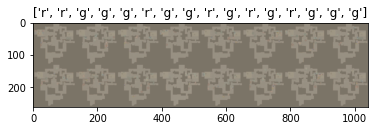

In [ ]:
def imshow(inp, title=None):
    """Imshow for Tensor."""
    inp = inp.numpy().transpose((1, 2, 0))
    mean = np.array([0.485, 0.456, 0.406])
    std = np.array([0.229, 0.224, 0.225])
    inp = std * inp + mean
    inp = np.clip(inp, 0, 1)
    plt.imshow(inp)
    if title is not None:
        plt.title(title)
    plt.pause(0.001)  # pause a bit so that plots are updated


# Get a batch of training data
inputs, classes = next(iter(dataloaders['train']))

# Make a grid from batch
out = torchvision.utils.make_grid(inputs)

imshow(out, title=[class_names[x] for x in classes])

In [ ]:
def train_model(model, criterion, optimizer, scheduler, num_epochs=25):
    since = time.time()

    best_model_wts = copy.deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        print(f'Epoch {epoch}/{num_epochs - 1}')
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    outputs = model(inputs)
                    _, preds = torch.max(outputs, 1)
                    loss = criterion(outputs, labels)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)
            if phase == 'train':
                scheduler.step()

            epoch_loss = running_loss / dataset_sizes[phase]
            epoch_acc = running_corrects.double() / dataset_sizes[phase]

            print(f'{phase} Loss: {epoch_loss:.4f} Acc: {epoch_acc:.4f}')

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = copy.deepcopy(model.state_dict())

        print()

    time_elapsed = time.time() - since
    print(f'Training complete in {time_elapsed // 60:.0f}m {time_elapsed % 60:.0f}s')
    print(f'Best val Acc: {best_acc:4f}')

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model

In [ ]:
def visualize_model(model, num_images=6):
    was_training = model.training
    model.eval()
    images_so_far = 0
    fig = plt.figure()

    with torch.no_grad():
        for i, (inputs, labels) in enumerate(dataloaders['val']):
            inputs = inputs.to(device)
            labels = labels.to(device)

            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)

            for j in range(inputs.size()[0]):
                images_so_far += 1
                ax = plt.subplot(num_images//2, 2, images_so_far)
                ax.axis('off')
                ax.set_title(f'predicted: {class_names[preds[j]]}')
                imshow(inputs.cpu().data[j])

                if images_so_far == num_images:
                    model.train(mode=was_training)
                    return
        model.train(mode=was_training)

In [ ]:
#download untrained model
model_ft = torchvision.models.resnet152(pretrained = False)


  0%|          | 0/100 [00:00<?, ?it/s]

Stopping early, the loss has diverged
Learning rate search finished. See the graph with {finder_name}.plot()
LR suggestion: steepest gradient
Suggested LR: 5.34E-04


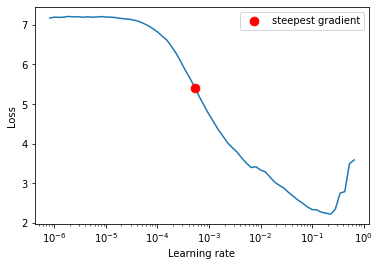

In [ ]:
# Use LR finder for best learning rate
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model_ft.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = LRFinder(model_ft, optimizer, criterion, device="cuda")
lr_finder.range_test(dataloaders['train'], end_lr=100, num_iter=100)
lr_finder.plot() # to inspect the loss-learning rate graph
lr_finder.reset() # to reset the model and optimizer to their initial state

In [ ]:
num_ftrs = model_ft.fc.in_features
# Here the size of each output sample is set to 2.
# Alternatively, it can be generalized to nn.Linear(num_ftrs, len(class_names)).
model_ft.fc = nn.Linear(num_ftrs, 2)

model_ft = model_ft.to(device)

criterion = nn.CrossEntropyLoss()

# Observe that all parameters are being optimized
optimizer_ft = optim.Adam(model_ft.parameters(), lr=5.34E-04, weight_decay=1e-2) #momentum=0.9)

# Decay LR by a factor of 0.1 every 7 epochs
exp_lr_scheduler = lr_scheduler.StepLR(optimizer_ft, step_size=7, gamma=0.1)

In [ ]:
model_ft = train_model(model_ft, criterion, optimizer_ft, exp_lr_scheduler,
                       num_epochs=30)

Epoch 0/29
----------
train Loss: 0.8218 Acc: 0.5096
val Loss: 0.6817 Acc: 0.5717

Epoch 1/29
----------
train Loss: 0.7056 Acc: 0.5489
val Loss: 0.7000 Acc: 0.5259

Epoch 2/29
----------
train Loss: 0.6820 Acc: 0.5688
val Loss: 3.2374 Acc: 0.4920

Epoch 3/29
----------
train Loss: 0.6751 Acc: 0.5849
val Loss: 0.6911 Acc: 0.5060

Epoch 4/29
----------
train Loss: 0.6435 Acc: 0.6377
val Loss: 0.6275 Acc: 0.6454

Epoch 5/29
----------
train Loss: 0.5945 Acc: 0.6810
val Loss: 0.5958 Acc: 0.6813

Epoch 6/29
----------
train Loss: 0.5754 Acc: 0.6958
val Loss: 0.6171 Acc: 0.6813

Epoch 7/29
----------
train Loss: 0.4146 Acc: 0.8144
val Loss: 0.5115 Acc: 0.7550

Epoch 8/29
----------
train Loss: 0.2921 Acc: 0.8809
val Loss: 0.4127 Acc: 0.8108

Epoch 9/29
----------
train Loss: 0.2430 Acc: 0.9092
val Loss: 0.6026 Acc: 0.7291

Epoch 10/29
----------
train Loss: 0.2114 Acc: 0.9216
val Loss: 0.7121 Acc: 0.7311

Epoch 11/29
----------
train Loss: 0.1857 Acc: 0.9331
val Loss: 1.1327 Acc: 0.5159

Ep

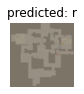

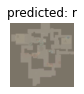

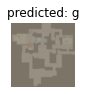

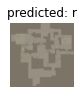

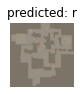

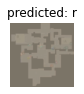

In [ ]:
visualize_model(model_ft)

In [ ]:
torch.save(model_ft,"/content/drive/MyDrive/models/model_best_resnet150_v2.pth")